In [2]:
# Check jupyter or not
from IPython import get_ipython
def type_of_script():
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str: return 'jupyter'
        if 'terminal' in ipy_str: return 'ipython'
    except: return 'terminal'
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm

# Default libraries
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects
from matplotlib import colormaps
from matplotlib.colors import Normalize
import cmasher as cmr
import numpy as np
import os, glob, atexit, signal, time, warnings
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# rur package
from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0

# Custom package
from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from common_func import *
from ramses_function import *

# Python Argument Parser
# print("ex: $ python3 06c_stable_tree.py [--mod 7]")
# import argparse
# parser = argparse.ArgumentParser(description='(syj3514@yonsei.ac.kr)')
# parser.add_argument("-m", "--mod", required=True, help='mod', type=int)
# args = parser.parse_args()
# mod = args.mod

In [3]:
ncpu=48
home = '/home/jeon'
if(not os.path.isdir(home)): home = '/gem_home/jeon'

In [4]:
mode1 = 'nh'; database1 = f"{home}/MissingSat/database/{mode1}"
iout1 = 1026; repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1); snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
# gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
# hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1, allsubs1, states1, dinks1, pairs1, upairs1 = extract_from_LG(LG1)
print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [5]:
mode2 = 'nh2'; database2 = f"{home}/MissingSat/database/{mode2}"
iout2 = 797; repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2); snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
# gals1 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
# hals1 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2, allsubs2, states2, dinks2, pairs2, upairs2 = extract_from_LG(LG2)
print(len(allsubs2), np.unique(states2, return_counts=True))  

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [6]:
stree1 = pklload(f"{database1}/stable_tree_new.pickle")
rtree1 = pklload(f"{database1}/stable_tree_raw.pickle")
print(stree1[list(stree1.keys())[0]].dtype.names)
stree2 = pklload(f"{database2}/stable_tree_new.pickle")
rtree2 = pklload(f"{database2}/stable_tree_raw.pickle")

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


In [7]:
casedict = {'NH':{'d':None, 'p':None, 'u':None}, 'NH2':{'d':None, 'p':None, 'u':None}}

# Case by Case

## Dink

### NH1

no star forever 345 15.23%
had stars, but not now 1111 49.05%
has stars 809 35.72%
no SF forever 1990 87.86%
had SF, but not now 273 12.05%
has SF 2 0.09%
No star
    No SF 345
    had SF 0
    has SF 0
Had star
    No SF 1054
    had SF 57
    has SF 0
Has star
    No SF 591
    had SF 216
    has SF 2


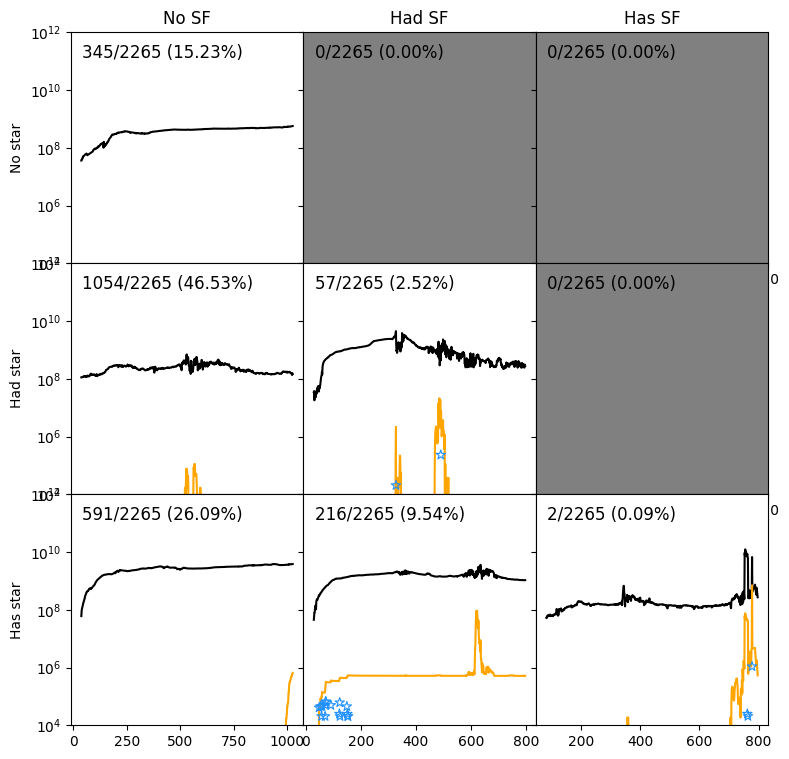

In [19]:
d1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for dink in dinks1:
    branch = stree1[dink['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0): d1cases[0][1].append(dink['id'])
    else:
        if(dink['mstar_vir']==0): d1cases[1][1].append(dink['id'])
        else: d1cases[2][1].append(dink['id'])
for dink in dinks2:
    branch = stree2[dink['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0): d1cases[0][1].append(-dink['id'])
    else:
        if(dink['mstar_vir']==0): d1cases[1][1].append(-dink['id'])
        else: d1cases[2][1].append(-dink['id'])
for case in d1cases:
    print(case[0], len(case[1]), f"{len(case[1])/(len(dinks1)+len(dinks2))*100:.2f}%")

d2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for dink in dinks1:
    branch = stree1[dink['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        d2cases[0][1].append(dink['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0): d2cases[1][1].append(dink['id'])
        else: d2cases[2][1].append(dink['id'])
for dink in dinks2:
    branch = stree2[dink['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        d2cases[0][1].append(-dink['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0): d2cases[1][1].append(-dink['id'])
        else: d2cases[2][1].append(-dink['id'])
for case in d2cases:
    print(case[0], len(case[1]), f"{len(case[1])/(len(dinks1)+len(dinks2))*100:.2f}%")

d1a = d1cases[0][1]; d1b = d1cases[1][1]; d1c = d1cases[2][1]
d2a = d2cases[0][1]; d2b = d2cases[1][1]; d2c = d2cases[2][1]
dcases = []
print('No star')
ids = np.array(d1a)[isin(d1a,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['No star',"No SF", ids])
ids = np.array(d1a)[isin(d1a,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['No star',"Had SF", ids])
ids = np.array(d1a)[isin(d1a,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(d1b)[isin(d1b,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Had star',"No SF", ids])
ids = np.array(d1b)[isin(d1b,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Had star',"Had SF", ids])
ids = np.array(d1b)[isin(d1b,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(d1c)[isin(d1c,d2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Has star',"No SF", ids])
ids = np.array(d1c)[isin(d1c,d2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Has star',"Had SF", ids])
ids = np.array(d1c)[isin(d1c,d2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Has star',"Has SF", ids])

fig, axes = plt.subplots(3,3, figsize=(9,9), sharey='row')
for i, case in enumerate(dcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    ax.text(0.05, 0.95, f"{len(ids)}/{len(dinks1)+len(dinks2)} ({len(ids)/(len(dinks1)+len(dinks2))*100:.2f}%)", ha='left', va='top', transform=ax.transAxes, fontsize=12)
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree1[iid] if(iid>0) else stree2[-iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.8)
    else:
        ax.set_facecolor('grey')
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"Dink_example.png", dpi=300, facecolor='w')
plt.show(); plt.close()

### How to do?
- (No star No SF): Normal: **just full movie**
- (Had star No SF): Whether interloper / stripping : **see star having period**
- (Has star No SF): Whether interloper / merging : **see star having period**

- (Had star Had SF): Whether interloper / stripping : **see star having period and SF epoch**
- (Has star Had SF): Whether interloper / stripping / merging : **see star having period and SF epoch**

## Pair

no star forever 0 0.00%
had stars, but not now 0 0.00%
has stars 209 100.00%
no SF forever 5 2.39%
had SF, but not now 137 65.55%
has SF 67 32.06%
No star
    No SF 0
    had SF 0
    has SF 0
Had star
    No SF 0
    had SF 0
    has SF 0
Has star
    No SF 5
    had SF 137
    has SF 67


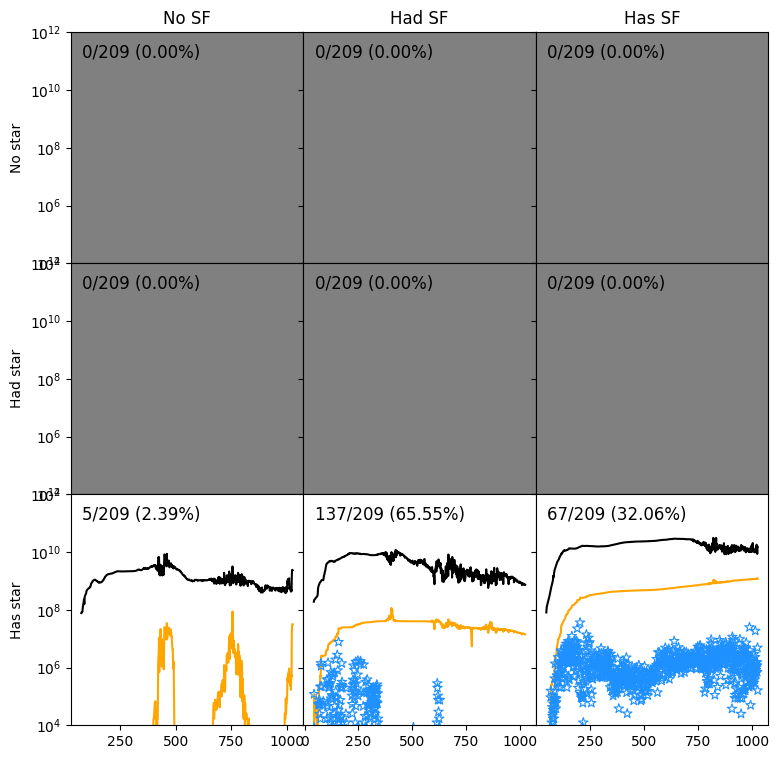

In [20]:
p1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for pair in pairs1:
    branch = stree1[pair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0): p1cases[0][1].append(pair['id'])
    else:
        if(pair['mstar_vir']==0): p1cases[1][1].append(pair['id'])
        else: p1cases[2][1].append(pair['id'])
for pair in pairs2:
    branch = stree2[pair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0): p1cases[0][1].append(-pair['id'])
    else:
        if(pair['mstar_vir']==0): p1cases[1][1].append(-pair['id'])
        else: p1cases[2][1].append(-pair['id'])
for case in p1cases:
    print(case[0], len(case[1]), f"{len(case[1])/(len(pairs1)+len(pairs2))*100:.2f}%")

p2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for pair in pairs1:
    branch = stree1[pair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        p2cases[0][1].append(pair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0): p2cases[1][1].append(pair['id'])
        else: p2cases[2][1].append(pair['id'])
for pair in pairs2:
    branch = stree2[pair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        p2cases[0][1].append(-pair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0): p2cases[1][1].append(-pair['id'])
        else: p2cases[2][1].append(-pair['id'])
for case in p2cases:
    print(case[0], len(case[1]), f"{len(case[1])/(len(pairs1)+len(pairs2))*100:.2f}%")

p1a = p1cases[0][1]; p1b = p1cases[1][1]; p1c = p1cases[2][1]
p2a = p2cases[0][1]; p2b = p2cases[1][1]; p2c = p2cases[2][1]
dcases = []
print('No star')
ids = np.array(p1a)[isin(p1a,p2a)]; print(f"    No SF {len(ids)}"); dcases.append(['No star',"No SF", ids])
ids = np.array(p1a)[isin(p1a,p2b)]; print(f"    had SF {len(ids)}"); dcases.append(['No star',"Had SF", ids])
ids = np.array(p1a)[isin(p1a,p2c)]; print(f"    has SF {len(ids)}"); dcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(p1b)[isin(p1b,p2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Had star',"No SF", ids])
ids = np.array(p1b)[isin(p1b,p2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Had star',"Had SF", ids])
ids = np.array(p1b)[isin(p1b,p2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(p1c)[isin(p1c,p2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Has star',"No SF", ids])
ids = np.array(p1c)[isin(p1c,p2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Has star',"Had SF", ids])
ids = np.array(p1c)[isin(p1c,p2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Has star',"Has SF", ids])

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(dcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    ax.text(0.05, 0.95, f"{len(ids)}/{len(pairs1)+len(pairs2)} ({len(ids)/(len(pairs1)+len(pairs2))*100:.2f}%)", ha='left', va='top', transform=ax.transAxes, fontsize=12)
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree1[iid] if(iid>0) else stree2[-iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.8)
    else:
        ax.set_facecolor('grey')
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"pair_example.png", dpi=300, facecolor='w')
plt.show(); plt.close()

### How to do?
- (Has star No SF): Just by recent merging? or interloper?: **See when it has stars**
- (Has star Had SF): Normal but why quenched? : **see quenching start**
- (Has star Has SF): Normal: **just full movie**

## Upair

no star forever 0 0.00%
had stars, but not now 0 0.00%
has stars 104 100.00%
no SF forever 54 51.92%
had SF, but not now 48 46.15%
has SF 2 1.92%
No star
    No SF 0
    had SF 0
    has SF 0
Had star
    No SF 0
    had SF 0
    has SF 0
Has star
    No SF 54
    had SF 48
    has SF 2


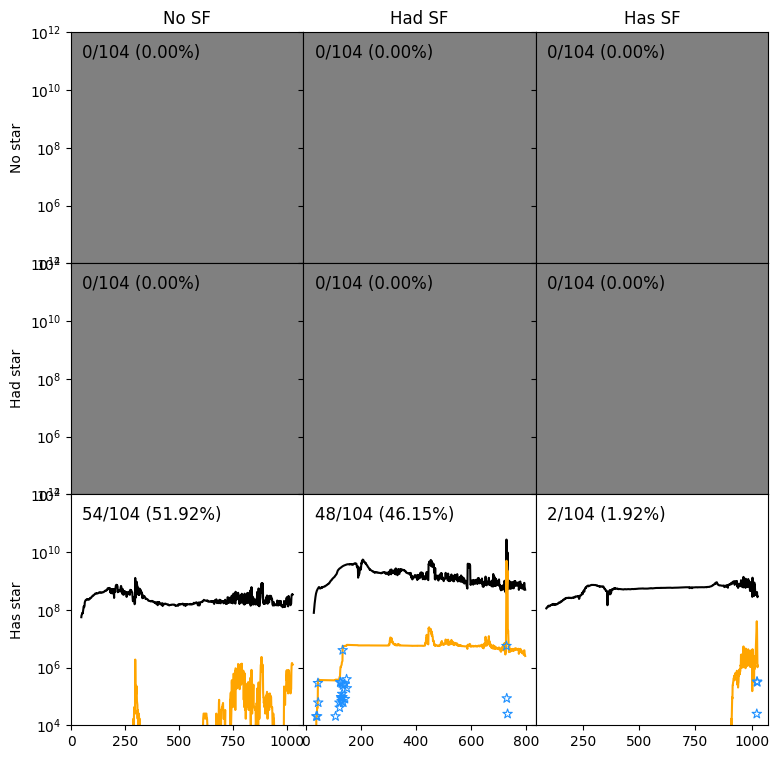

In [21]:
u1cases=[ ['no star forever',[]], ['had stars, but not now',[]], ['has stars',[]] ]
for upair in upairs1:
    branch = stree1[upair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0): u1cases[0][1].append(upair['id'])
    else:
        if(upair['mstar_vir']==0): u1cases[1][1].append(upair['id'])
        else: u1cases[2][1].append(upair['id'])
for upair in upairs2:
    branch = stree2[upair['id']]
    mstar = branch['mstar_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0): u1cases[0][1].append(-upair['id'])
    else:
        if(upair['mstar_vir']==0): u1cases[1][1].append(-upair['id'])
        else: u1cases[2][1].append(-upair['id'])
for case in u1cases:
    print(case[0], len(case[1]), f"{len(case[1])/(len(upairs1)+len(upairs2))*100:.2f}%")

u2cases=[ ['no SF forever',[]], ['had SF, but not now',[]], ['has SF',[]] ]
for upair in upairs1:
    branch = stree1[upair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        u2cases[0][1].append(upair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0): u2cases[1][1].append(upair['id'])
        else: u2cases[2][1].append(upair['id'])
for upair in upairs2:
    branch = stree2[upair['id']]
    mstar = branch['insitu_vir']
    hasstar = mstar>0
    if(np.sum(hasstar) == 0):
        u2cases[0][1].append(-upair['id'])
    else:
        if(np.sum(branch[:10]['insitu_vir'])==0): u2cases[1][1].append(-upair['id'])
        else: u2cases[2][1].append(-upair['id'])
for case in u2cases:
    print(case[0], len(case[1]), f"{len(case[1])/(len(upairs1)+len(upairs2))*100:.2f}%")

u1a = u1cases[0][1]; u1b = u1cases[1][1]; u1c = u1cases[2][1]
u2a = u2cases[0][1]; u2b = u2cases[1][1]; u2c = u2cases[2][1]
dcases = []
print('No star')
ids = np.array(u1a)[isin(u1a,u2a)]; print(f"    No SF {len(ids)}"); dcases.append(['No star',"No SF", ids])
ids = np.array(u1a)[isin(u1a,u2b)]; print(f"    had SF {len(ids)}"); dcases.append(['No star',"Had SF", ids])
ids = np.array(u1a)[isin(u1a,u2c)]; print(f"    has SF {len(ids)}"); dcases.append(['No star',"Has SF", ids])
print('Had star')
ids = np.array(u1b)[isin(u1b,u2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Had star',"No SF", ids])
ids = np.array(u1b)[isin(u1b,u2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Had star',"Had SF", ids])
ids = np.array(u1b)[isin(u1b,u2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Had star',"Has SF", ids])
print('Has star')
ids = np.array(u1c)[isin(u1c,u2a)]; print(f"    No SF {len(ids)}"); dcases.append(['Has star',"No SF", ids])
ids = np.array(u1c)[isin(u1c,u2b)]; print(f"    had SF {len(ids)}"); dcases.append(['Has star',"Had SF", ids])
ids = np.array(u1c)[isin(u1c,u2c)]; print(f"    has SF {len(ids)}"); dcases.append(['Has star',"Has SF", ids])

fig, axes = plt.subplots(3,3, figsize=(9,9), sharex='col', sharey='row')
for i, case in enumerate(dcases):
    ax = axes.flatten()[i]
    str1, str2, ids = case
    ax.text(0.05, 0.95, f"{len(ids)}/{len(upairs1)+len(upairs2)} ({len(ids)/(len(upairs1)+len(upairs2))*100:.2f}%)", ha='left', va='top', transform=ax.transAxes, fontsize=12)
    if(len(ids)>0):
        iid = np.random.choice(ids)
        branch = stree1[iid] if(iid>0) else stree2[-iid]
        ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
        ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
        ax.scatter(branch['timestep'], branch['insitu_vir'], fc='none', ec='dodgerblue', marker='*', s=50, zorder=3, lw=0.8)
    else:
        ax.set_facecolor('grey')
    ax.set_yscale('log')
    ax.set_ylim(1e4,1e12)

    # Top row
    if(i//3 == 0):
        ax.set_title(str2)
    if(i%3 == 0):
        ax.set_ylabel(str1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"upair_example.png", dpi=300, facecolor='w')
plt.show(); plt.close()

### How to do?
- (Has star No SF): Just by recent merging? or interloper?: **See when it has stars**
- (Has star Had SF): Normal but why quenched? : **see quenching start**

In [39]:
pklsave(casedict['NH'], f"{database1}/case_dict.pickle")
pklsave(casedict['NH2'], f"{database2}/case_dict.pickle")